In [15]:
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns


# Creating Spotify Data Frame

The code loads multiple JSON files from a specified directory, combines their data, and creates a DataFrame.
It displays the first few rows of the DataFrame to inspect the loaded data.
The combined data is then saved to a CSV file named "spotify_data.csv"


In [ ]:

directory_path = './'  

all_data = []

for filename in os.listdir(directory_path):
    if filename.endswith('.json'):
        file_path = os.path.join(directory_path, filename)
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)
            all_data.extend(data)  


df = pd.DataFrame(all_data)


print("Displaying the first few rows of the dataset:")
print(df.head())

df.to_csv('spotify_data.csv', index=False)


pd.set_option('display.max_columns', None)
print(df.head())

print("Data loaded into DataFrame and saved as 'spotify_data.csv'.")



Displaying the first few rows of the dataset:
                     ts                      platform  ms_played conn_country  \
0  2019-09-28T22:26:41Z        iOS 10.3.3 (iPhone9,3)      10943           TR   
1  2019-09-28T22:26:58Z        iOS 10.3.3 (iPhone9,3)      15722           TR   
2  2019-09-29T07:02:57Z        iOS 10.3.3 (iPhone9,3)      10938           TR   
3  2019-09-29T07:03:19Z        iOS 10.3.3 (iPhone9,3)      15722           TR   
4  2019-09-29T08:43:24Z  Windows 10 (10.0.18362; x64)       4985           TR   

        ip_addr master_metadata_track_name master_metadata_album_artist_name  \
0  94.54.248.68                       None                              None   
1  94.54.248.68                       None                              None   
2  94.54.248.68                       None                              None   
3  94.54.248.68                       None                              None   
4  94.54.248.68                       None                         

# Top 10 Most Listened Artists

The code loads artist playtime data, aggregates it to get the total playtime for each artist, sorts the artists by total playtime, and then creates a bar plot to display the top 10 most listened artists with their corresponding total playtime in seconds.

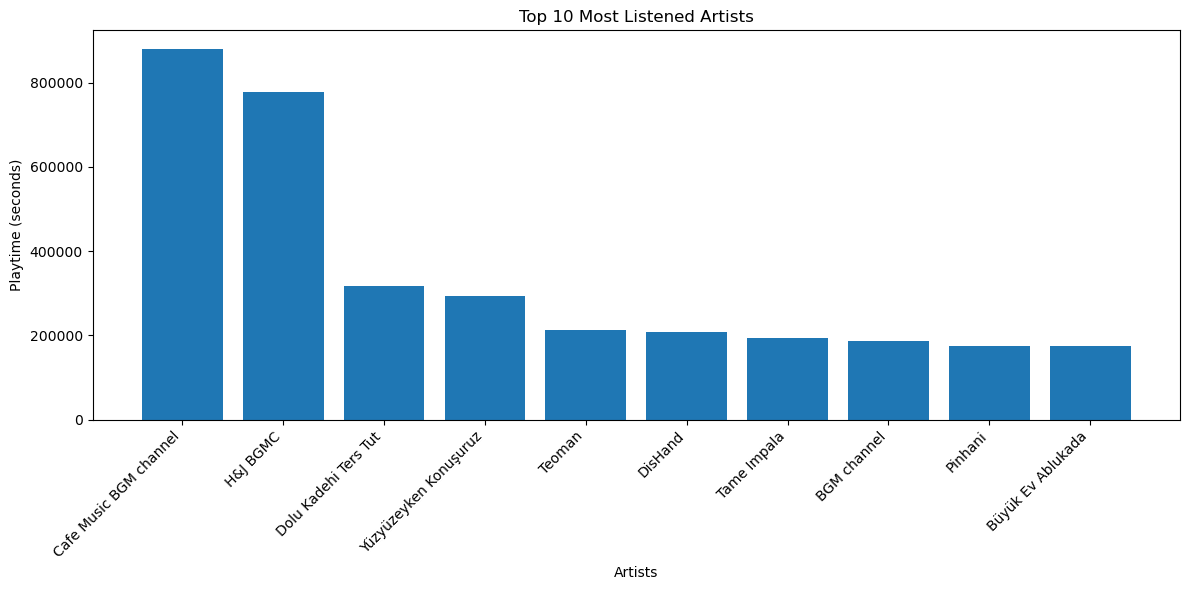

Data loaded, analyzed, and histogram displayed.


In [ ]:
artist_playtime = df[['master_metadata_album_artist_name', 'ms_played']].dropna()


artist_playtime = artist_playtime.groupby('master_metadata_album_artist_name', as_index=False).sum()


artist_playtime = artist_playtime.sort_values('ms_played', ascending=False)


plt.figure(figsize=(12, 6))
plt.bar(artist_playtime['master_metadata_album_artist_name'][:10], artist_playtime['ms_played'][:10] / 1000)  # Convert ms to seconds
plt.xticks(rotation=45, ha='right')
plt.xlabel('Artists')
plt.ylabel('Playtime (seconds)')
plt.title('Top 10 Most Listened Artists')
plt.tight_layout()
plt.show()

print("Data loaded, analyzed, and histogram displayed.")

# Top 10 most listened songs

The code analyzes the song playtime data, aggregates it by song, sorts the songs by playtime, and then displays a bar plot showing the top 10 most listened songs with their playtimes.

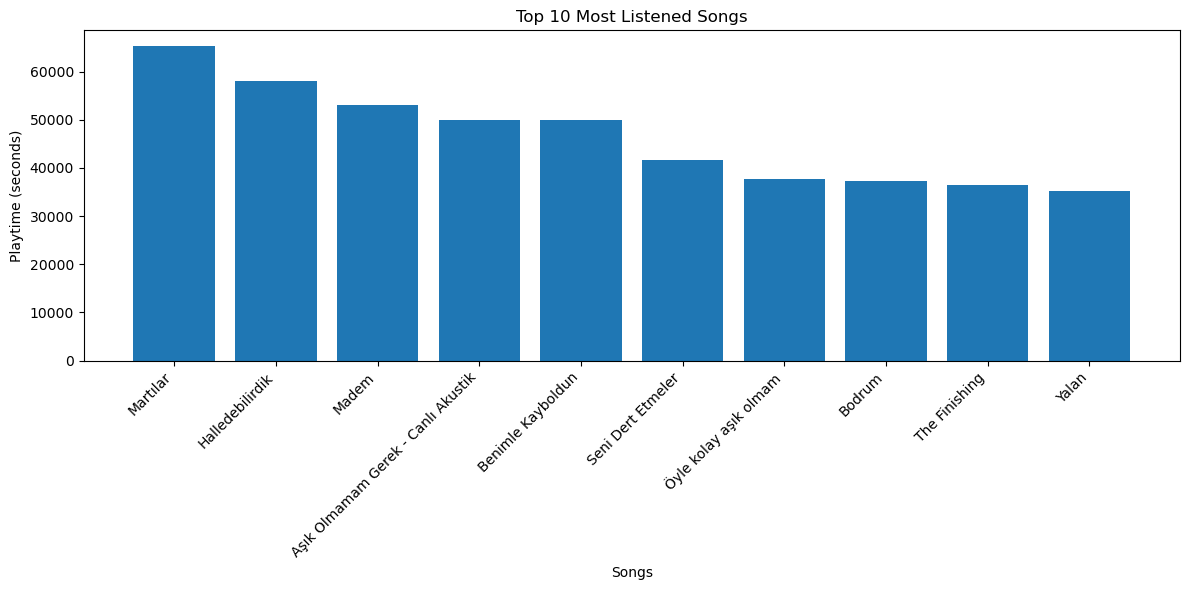

Data loaded, analyzed, and histogram for most listened songs displayed.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


song_playtime = df[['master_metadata_track_name', 'ms_played']].dropna()

song_playtime = song_playtime.groupby('master_metadata_track_name', as_index=False).sum()

song_playtime = song_playtime.sort_values('ms_played', ascending=False)


plt.figure(figsize=(12, 6))
plt.bar(song_playtime['master_metadata_track_name'][:10], song_playtime['ms_played'][:10] / 1000)  # Convert ms to seconds
plt.xticks(rotation=45, ha='right')
plt.xlabel('Songs')
plt.ylabel('Playtime (seconds)')
plt.title('Top 10 Most Listened Songs')
plt.tight_layout()
plt.show()

print("Data loaded, analyzed, and histogram for most listened songs displayed.")


# Listening Duration Per Year

This code extracts and processes the data , group it by year and converts playtime to hour and display in a bar chart.

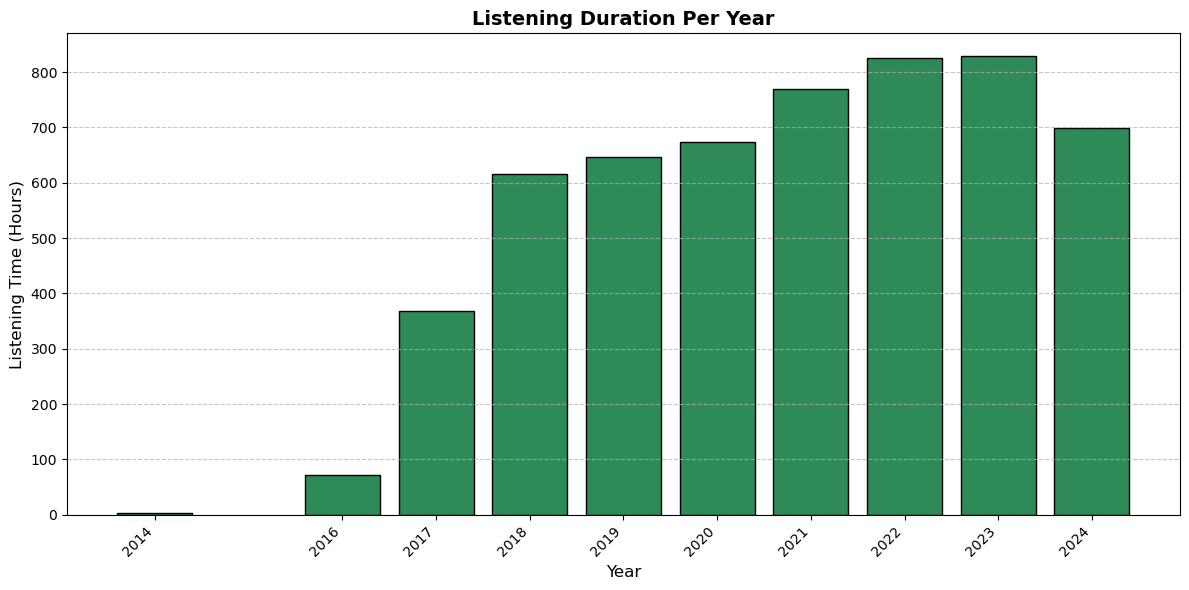

Listening duration per year has been analyzed and displayed.


In [ ]:

yearly_playtime = df[['ts', 'ms_played']].dropna()

yearly_playtime['ts'] = pd.to_datetime(yearly_playtime['ts'])

yearly_playtime['Year'] = yearly_playtime['ts'].dt.year

yearly_playtime = yearly_playtime.groupby('Year', as_index=False)['ms_played'].sum()


plt.figure(figsize=(12, 6))
plt.bar(
    yearly_playtime['Year'], 
    yearly_playtime['ms_played'] / (1000 * 60 * 60),  
    color='seagreen', edgecolor='black'
)
plt.xticks(yearly_playtime['Year'], rotation=45, ha='right', fontsize=10)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Listening Time (Hours)', fontsize=12)
plt.title('Listening Duration Per Year', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("Listening duration per year has been analyzed and displayed.")


# Grouped Artists CSV

This code filters relevant columns (artist_name, track_name, and ms_played) from the dataset and drops any missing values. Than, saves the summarized data to a CSV file named 'Grouped_Artists.csv'.

In [ ]:
filtered_data = df[['master_metadata_album_artist_name', 'master_metadata_track_name', 'ms_played']].dropna()

filtered_data.rename(columns={
    'master_metadata_album_artist_name': 'artist_name',
    'master_metadata_track_name': 'track_name',
    'ms_played': 'track_time_ms'
}, inplace=True)


summary = filtered_data.groupby('artist_name').agg(
    total_minutes=('track_time_ms', lambda x: x.sum() / 60000),  
    track_count=('track_name', 'nunique')  
).reset_index()


summary.to_csv('Grouped_Artists.csv', index=False)

print("CSV file 'Grouped_Artists.csv' has been created with artist names, total minutes, and track counts.")

CSV file 'Grouped_Artists.csv' has been created with artist names, total minutes, and track counts.


# SPOTIFY API

This code fetches genre information for artists from Spotify, processes artists with more than 10 tracks, and stores the genre data in a CSV file (Artist_Data_with_Genres.csv). It uses a cache (Artist_Genre_Cache.csv) to avoid redundant API calls and updates the cache after each batch of artists. The script processes artists in batches of 10, throttling API requests, and saves the results after each batch.

In [ ]:
import pandas as pd
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy
import time
import os

#  Spotify API credentials
client_id = '0d584a31f10a4985b0b9290a43610b8e'
client_secret = '69057b41afc74f30abafd98419189c32'

# Authenticate with Spotify API
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=client_id, client_secret=client_secret))

file_path = "Grouped_Artists.csv"  # Replace with the correct file path
artist_data = pd.read_csv(file_path)


artists_filtered = artist_data[artist_data['track_count'] > 10].reset_index(drop=True)

if 'genres' not in artists_filtered.columns:
    artists_filtered['genres'] = None


cache_path = "Artist_Genre_Cache.csv"
if os.path.exists(cache_path):
    cache = pd.read_csv(cache_path).set_index('artist_name')['genres'].to_dict()
else:
    cache = {}


def fetch_genres_batch(artist_names):
    genre_mapping = {}
    for artist_name in artist_names:
        if artist_name in cache:
            genre_mapping[artist_name] = cache[artist_name]
        else:
            try:
                results = sp.search(q='artist:' + artist_name, type='artist', limit=1)
                if results['artists']['items']:
                    genres = results['artists']['items'][0]['genres']
                    genre_mapping[artist_name] = ", ".join(genres)
                    cache[artist_name] = genre_mapping[artist_name]
                else:
                    genre_mapping[artist_name] = "Unknown"
                    cache[artist_name] = "Unknown"
            except Exception as e:
                print(f"Error fetching genres for {artist_name}: {e}")
                genre_mapping[artist_name] = "Error"
                cache[artist_name] = "Error"
            time.sleep(0.2)  # Throttle API requests
    return genre_mapping

# Batch process artists
batch_size = 10
output_file = "Artist_Data_with_Genres.csv"
for i in range(0, len(artists_filtered), batch_size):
    batch = artists_filtered.iloc[i:i + batch_size]
    artist_names = batch['artist_name']
    genres_batch = fetch_genres_batch(artist_names)

  
    for index, artist_name in enumerate(artist_names):
        if pd.isna(artists_filtered.at[i + index, 'genres']):
            artists_filtered.at[i + index, 'genres'] = genres_batch.get(artist_name, "Unknown")

  
    artists_filtered.to_csv(output_file, index=False)
    # Save cache
    pd.DataFrame.from_dict(cache, orient='index', columns=['genres']).to_csv(cache_path)
    print(f"Processed batch {i // batch_size + 1} of {len(artists_filtered) // batch_size + 1}")

# Final save
artists_filtered.to_csv(output_file, index=False)
pd.DataFrame.from_dict(cache, orient='index', columns=['genres']).to_csv(cache_path)
print(f"Genres fetched and saved to {output_file}")


Processed batch 1 of 42
Processed batch 2 of 42
Processed batch 3 of 42
Processed batch 4 of 42
Processed batch 5 of 42
Processed batch 6 of 42
Processed batch 7 of 42
Processed batch 8 of 42
Processed batch 9 of 42
Processed batch 10 of 42
Processed batch 11 of 42
Processed batch 12 of 42
Processed batch 13 of 42
Processed batch 14 of 42
Processed batch 15 of 42
Processed batch 16 of 42
Processed batch 17 of 42
Processed batch 18 of 42
Processed batch 19 of 42
Processed batch 20 of 42
Processed batch 21 of 42
Processed batch 22 of 42
Processed batch 23 of 42
Processed batch 24 of 42
Processed batch 25 of 42
Processed batch 26 of 42
Processed batch 27 of 42
Processed batch 28 of 42
Processed batch 29 of 42
Processed batch 30 of 42
Processed batch 31 of 42
Processed batch 32 of 42
Processed batch 33 of 42
Processed batch 34 of 42
Processed batch 35 of 42
Processed batch 36 of 42
Processed batch 37 of 42
Processed batch 38 of 42
Processed batch 39 of 42
Processed batch 40 of 42
Processed

In [ ]:

artist_df = pd.read_csv('Grouped_Artists.csv')
print(artist_df.columns)


Index(['artist_name', 'total_minutes', 'track_count'], dtype='object')


# Top 10 Most Listened Genres

This code loads artist data, filters out rows without genre information, and calculates the total listening time for each genre. It then sorts the genres by total listening time and plots a bar chart showing the top 10 most listened genres.

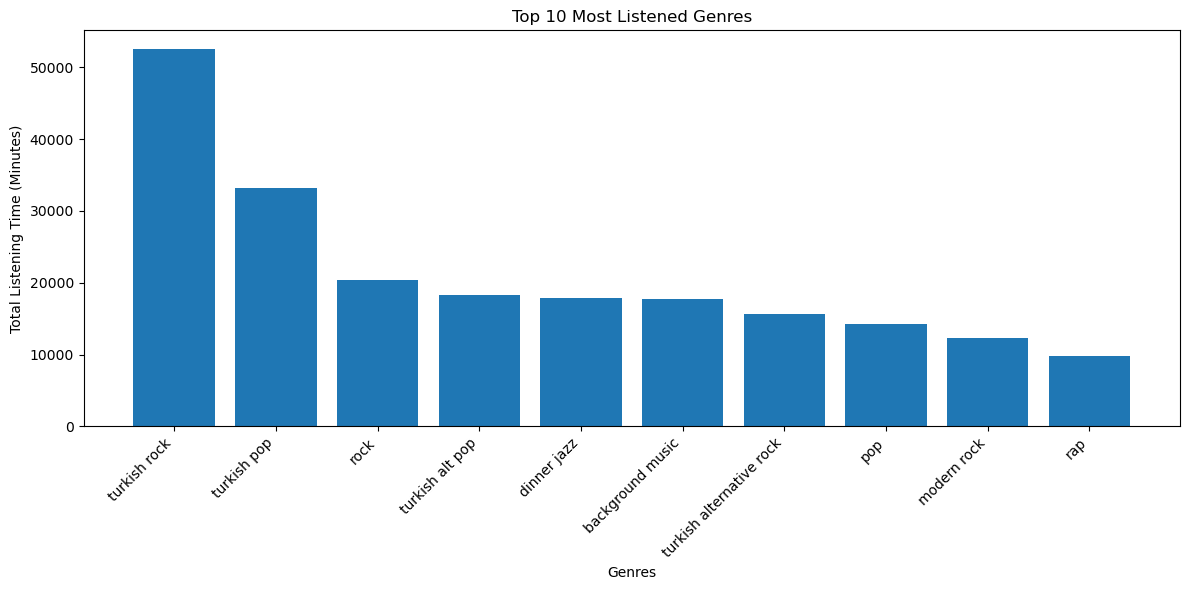

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


file_path = "Artist_Data_with_Genres.csv"  
artist_data = pd.read_csv(file_path)

artist_data = artist_data.dropna(subset=['genres'])

genre_playtime = {}


for _, row in artist_data.iterrows():
    genres = row['genres'].split(', ') 
    playtime = row['total_minutes']  
    for genre in genres:
        genre_playtime[genre] = genre_playtime.get(genre, 0) + playtime


genre_df = pd.DataFrame(list(genre_playtime.items()), columns=['genre', 'total_minutes'])


genre_df = genre_df.sort_values(by='total_minutes', ascending=False)


top_genres = genre_df.head(10)
plt.figure(figsize=(12, 6))
plt.bar(top_genres['genre'], top_genres['total_minutes'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Genres')
plt.ylabel('Total Listening Time (Minutes)')
plt.title('Top 10 Most Listened Genres')
plt.tight_layout()
plt.show()


# Top 1O Most Listened Genre in Minutes

I have found  the top 10 most listened genres and showed the amount of time spent listening to each genre in minutes.

In [ ]:
import pandas as pd


file_path = "Artist_Data_with_Genres.csv"  
artist_data = pd.read_csv(file_path)


artist_data = artist_data.dropna(subset=['genres'])


genre_playtime = {}

for _, row in artist_data.iterrows():
    genres = row['genres'].split(', ') 
    playtime = row['total_minutes']  
    for genre in genres:
        genre_playtime[genre] = genre_playtime.get(genre, 0) + playtime


genre_df = pd.DataFrame(list(genre_playtime.items()), columns=['genre', 'total_minutes'])


genre_df = genre_df.sort_values(by='total_minutes', ascending=False)


top_genres = genre_df.head(10)
print("Top 10 Most Listened Genres (with their total listening time in minutes):")
print(top_genres[['genre', 'total_minutes']])


Top 10 Most Listened Genres (with their total listening time in minutes):
                       genre  total_minutes
15              turkish rock   52518.206417
20               turkish pop   33200.068333
12                      rock   20377.925350
72           turkish alt pop   18323.856583
53               dinner jazz   17862.402917
52          background music   17776.212383
92  turkish alternative rock   15620.686750
23                       pop   14246.456067
42               modern rock   12272.148983
3                        rap    9791.100133


#  Ratio of Turkish Songs to All Songs 

 the code shows how much of the total listening time is spent on Turkish songs compared to other songs and visualizes the ratio with a pie chart

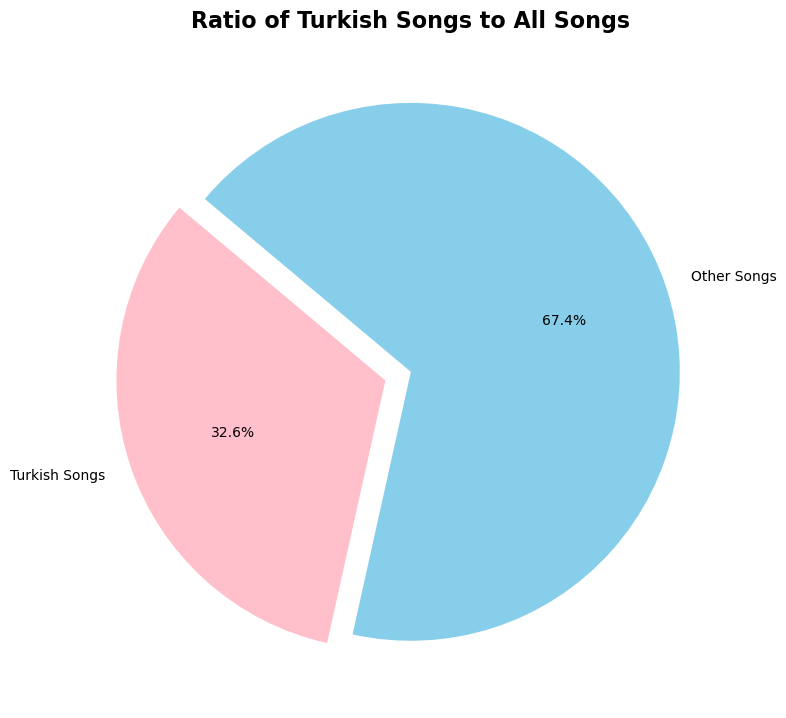

Total Listening Time (Minutes): 461258.75435
Turkish Songs Listening Time (Minutes): 150525.16273333333
Ratio of Turkish Songs to All Songs: 32.63%


In [ ]:


file_path = "Artist_Data_with_Genres.csv" 
artist_data = pd.read_csv(file_path)

artist_data = artist_data.dropna(subset=['genres'])

genre_playtime = {}


for _, row in artist_data.iterrows():
    genres = row['genres'].split(', ') 
    playtime = row['total_minutes'] 
    for genre in genres:
        genre_playtime[genre] = genre_playtime.get(genre, 0) + playtime


genre_df = pd.DataFrame(list(genre_playtime.items()), columns=['genre', 'total_minutes'])


total_songs_playtime = genre_df['total_minutes'].sum()
turkish_songs_playtime = genre_df.loc[genre_df['genre'].str.contains('Turkish', case=False, na=False), 'total_minutes'].sum()


labels = ['Turkish Songs', 'Other Songs']
sizes = [turkish_songs_playtime, total_songs_playtime - turkish_songs_playtime]
colors = ['pink', 'skyblue']
explode = (0.1, 0) 


plt.figure(figsize=(8, 8))
plt.pie(
    sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, explode=explode
)
plt.title('Ratio of Turkish Songs to All Songs', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


turkish_song_ratio = turkish_songs_playtime / total_songs_playtime if total_songs_playtime > 0 else 0
print(f"Total Listening Time (Minutes): {total_songs_playtime}")
print(f"Turkish Songs Listening Time (Minutes): {turkish_songs_playtime}")
print(f"Ratio of Turkish Songs to All Songs: {turkish_song_ratio:.2%}")



# Total Number Of Things Watched Per Year

The code visualizes the number of Netflix items watched each year, displaying a bar chart with labels showing the count for each year.

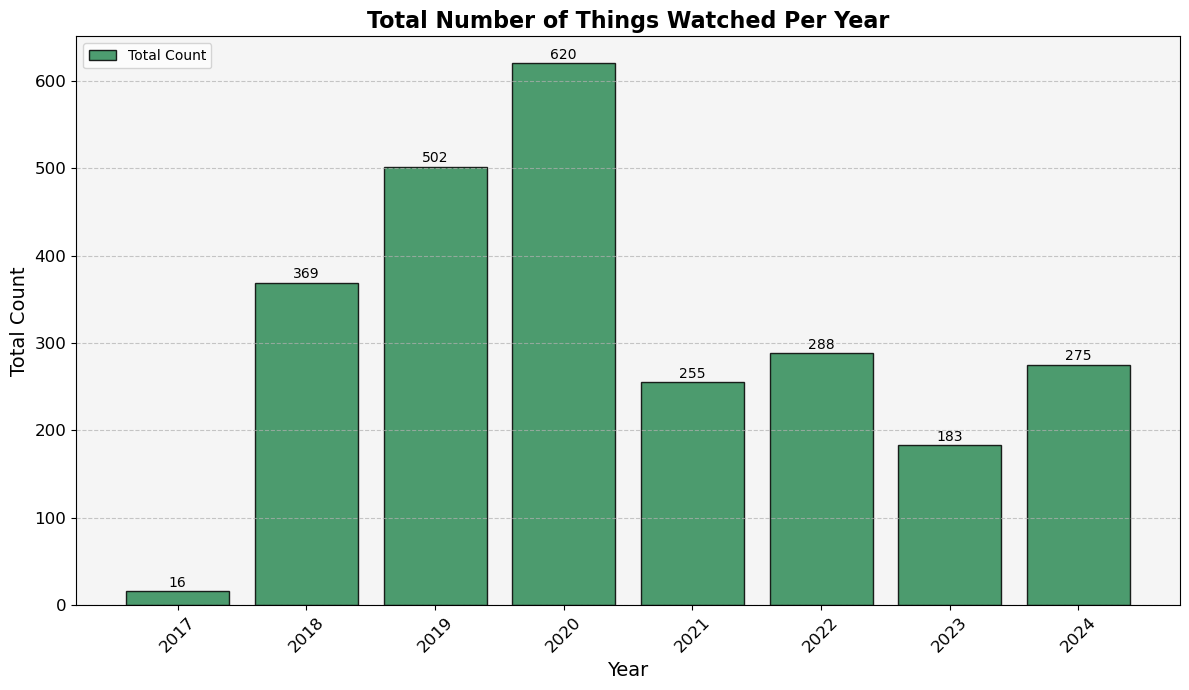

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = "NetflixViewingHistory (1).csv"  


netflix_data = pd.read_csv(file_path)

netflix_data = netflix_data.dropna(subset=['Title'])

netflix_data['Date'] = pd.to_datetime(netflix_data['Date'], format='%m/%d/%y')


netflix_data['Year'] = netflix_data['Date'].dt.year


total_per_year = netflix_data.groupby('Year')['Title'].count()

plt.figure(figsize=(12, 7)) 
bars = plt.bar(
    total_per_year.index, total_per_year.values, 
    color='seagreen', edgecolor='black', alpha=0.85  
)


for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, 
             f'{int(bar.get_height())}', ha='center', fontsize=10)


plt.grid(axis='y', linestyle='--', alpha=0.7)


plt.title('Total Number of Things Watched Per Year', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Total Count', fontsize=14)


plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)


plt.legend(['Total Count'], loc='upper left')


plt.gca().set_facecolor('#f5f5f5') 
plt.tight_layout()


plt.show()


# Correlation Matrix Between Listening Time and Watching Frequency 

The code processes the Spotify listening and Netflix watching data, computes the correlation between listening time and watching frequency for each year, and visualizes this relationship with a heatmap. The heatmap allows for a visual assessment of how closely the two activities (Spotify listening and Netflix watching) are correlated across years.

Overall, the heatmap shows the strength of the correlation between listening time and watching frequency, with the strongest correlation being between year and total hours, followed by a mild correlation between listening time and watching frequency. So we can say that, there is a week correlation in the allocated time between listening songs and watching movies


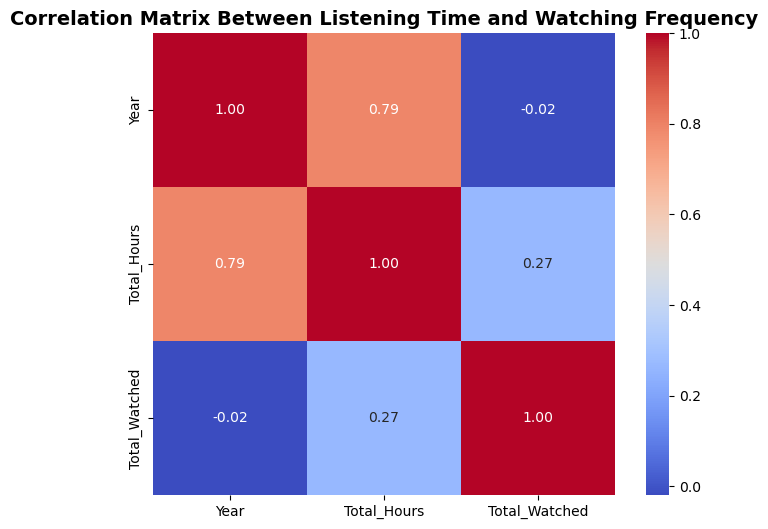

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


spotify_per_year = df[['ts', 'ms_played']].dropna()  
spotify_per_year['ts'] = pd.to_datetime(spotify_per_year['ts'])  
spotify_per_year['Year'] = spotify_per_year['ts'].dt.year  
spotify_per_year = spotify_per_year.groupby('Year', as_index=False)['ms_played'].sum()  
spotify_per_year['Total_Hours'] = spotify_per_year['ms_played'] / (1000 * 60 * 60) 


netflix_data = netflix_data.dropna(subset=['Title'])  
netflix_data['Date'] = pd.to_datetime(netflix_data['Date'], format='%m/%d/%y')  
netflix_data['Year'] = netflix_data['Date'].dt.year  
netflix_per_year = netflix_data.groupby('Year', as_index=False)['Title'].count()  
netflix_per_year.columns = ['Year', 'Total_Watched']


merged_data = pd.merge(spotify_per_year[['Year', 'Total_Hours']], netflix_per_year, on='Year', how='inner')


correlation_matrix = merged_data.corr()


plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True, square=True)
plt.title('Correlation Matrix Between Listening Time and Watching Frequency', fontsize=14, fontweight='bold')
plt.show()


Creating Dataframe for Netflix

This code loads a Netflix viewing history CSV and create a new CSV file called Unique_Movies_and_Series.csv. It also prints the first few unique titles to the console.

In [ ]:
import pandas as pd


file_path = "NetflixViewingHistory (1).csv"  

netflix_data = pd.read_csv(file_path)

netflix_data = netflix_data.dropna(subset=['Title'])


netflix_data['Series_Name'] = netflix_data['Title'].apply(lambda x: x.split(':')[0].strip())


unique_titles = netflix_data['Series_Name'].drop_duplicates()


unique_titles.to_csv("Unique_Movies_and_Series.csv", index=False, header=["Title"])

print("Unique Movies and TV Series:")
print(unique_titles.head())

print("\nThe list of unique movies and TV series has been saved to 'Unique_Movies_and_Series.csv'.")



Unique Movies and TV Series:
0                                 Friends
1                       Nobody Wants This
11    The Life and Movies of Erşan Kuneri
17                       American Factory
18                         Emily in Paris
Name: Series_Name, dtype: object

The list of unique movies and TV series has been saved to 'Unique_Movies_and_Series.csv'.


# TMDB API ANALYSIS

In this process, I used the TMDb API to gather additional details about the movies and TV shows I watched, based on my Netflix viewing history. I created a movie list on TMDb, excluding movies I haven't watched to improve the accuracy of the analysis. The script fetches movie genre information from TMDb and stores it in a DataFrame. It then maps genre IDs to genre names, selects key columns (like title, overview, release date, etc.), and saves the data in a CSV file for further analysis. The movie list with genre information is saved as tmdb_movie_list_with_genres.csv.

https://www.themoviedb.org/list/8506092-dsa210?view=grid

In [ ]:
import requests
import pandas as pd

# TMDb API details
api_key = "ab5c0b7fbfd8f6fc1155189877b0d4c0"
base_url = "https://api.themoviedb.org/3"


genre_url = f"{base_url}/genre/movie/list"
params = {"api_key": api_key}
response = requests.get(genre_url, params=params)

if response.status_code == 200:
    genre_data = response.json()
    genre_mapping = {genre['id']: genre['name'] for genre in genre_data['genres']}
    print("Genre mapping fetched successfully!")
else:
    print(f"Failed to fetch genre mapping. Status code: {response.status_code}")
    genre_mapping = {}

list_id = "8506092"


all_movies = []


page = 1
while True:
   
    url = f"{base_url}/list/{list_id}"
    params = {
        "api_key": api_key,
        "page": page
    }
    response = requests.get(url, params=params)
    
    if response.status_code == 200:
     
        data = response.json()

        all_movies.extend(data.get("items", []))

        if page >= data.get("total_pages", 1):
            break


        page += 1
    else:
        print(f"Failed to fetch data from TMDb API. Status code: {response.status_code}")
        print(response.json())  
        break


df = pd.DataFrame(all_movies)

def map_genres(genre_ids):
    if isinstance(genre_ids, list):
        return ", ".join([genre_mapping.get(genre_id, "Unknown") for genre_id in genre_ids])
    return "Unknown"

df['genres'] = df['genre_ids'].apply(map_genres)


selected_columns = ["title", "overview", "release_date", "vote_average", "vote_count", "genres"]
df = df[selected_columns]


df.to_csv("tmdb_movie_list_with_genres.csv", index=False)

print("Movie data with genres successfully saved to 'tmdb_movie_list_with_genres.csv'.")
print(df.head())  


Genre mapping fetched successfully!
Movie data with genres successfully saved to 'tmdb_movie_list_with_genres.csv'.
              title                                           overview  \
0               NaN  Six young people from New York City, on their ...   
1               NaN  An agnostic sex podcaster and a newly single r...   
2               NaN  Reexamining his own legacy, a renowned figure ...   
3  American Factory  In post-industrial Ohio, a Chinese billionaire...   
4               NaN  When ambitious Chicago marketing exec Emily un...   

  release_date  vote_average  vote_count         genres  
0          NaN         8.400        8126         Comedy  
1          NaN         7.569         130  Comedy, Drama  
2          NaN         6.844          61         Comedy  
3   2019-08-21         7.200         453    Documentary  
4          NaN         7.700        1379  Drama, Comedy  


Most Watched Movie Genres

I displayed my most watched movie genres based on the TMDB list I created using my Netflix data.

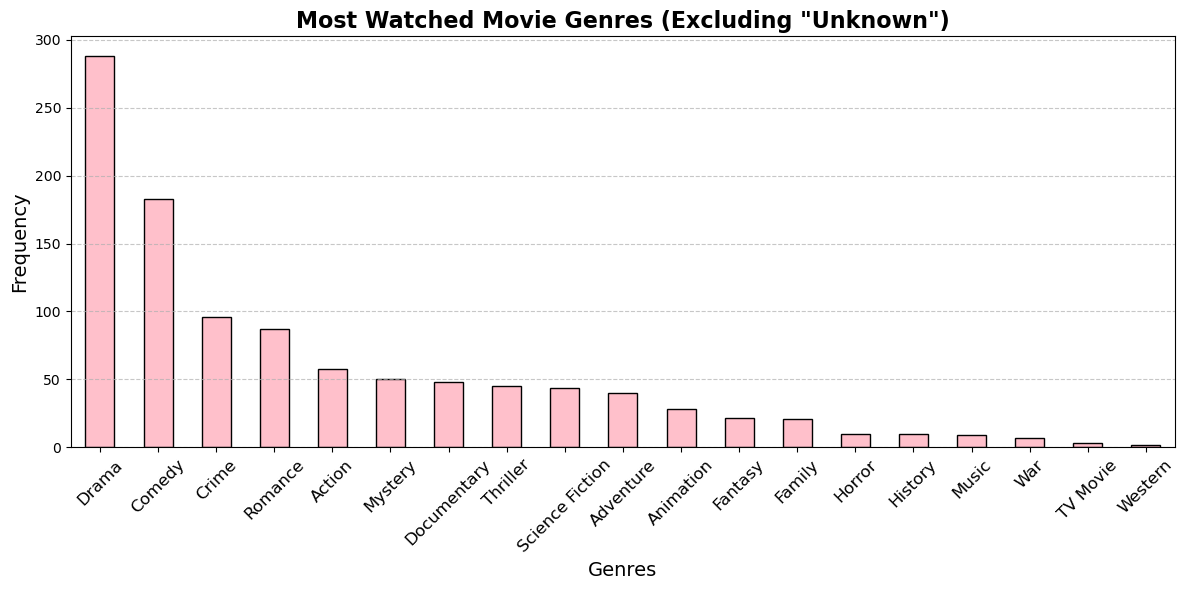

Most Watched Genres (excluding 'Unknown'):
genres
Drama              288
Comedy             183
Crime               96
Romance             87
Action              58
Mystery             50
Documentary         48
Thriller            45
Science Fiction     44
Adventure           40
Animation           28
Fantasy             22
Family              21
Horror              10
History             10
Music                9
War                  7
TV Movie             3
Western              2
Name: count, dtype: int64


In [ ]:

file_path = "tmdb_movie_list_with_genres.csv"  
df = pd.read_csv(file_path)

df['genres'] = df['genres'].str.split(", ")  
df_exploded = df.explode('genres')  

df_exploded = df_exploded[df_exploded['genres'] != 'Unknown']

genre_counts = df_exploded['genres'].value_counts()

plt.figure(figsize=(12, 6))
genre_counts.plot(kind='bar', color='pink', edgecolor='black') 
plt.title('Most Watched Movie Genres (Excluding "Unknown")', fontsize=16, fontweight='bold')
plt.xlabel('Genres', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


print("Most Watched Genres (excluding 'Unknown'):")
print(genre_counts)



# TMDb API Fetching 

I fetches movie data from the TMDb API, including genres and original language, processes the data, and saved it into a CSV file named "tmdb_movie_list_with_genres.csv" .

In [ ]:
import requests
import pandas as pd

# TMDb API details
api_key = "ab5c0b7fbfd8f6fc1155189877b0d4c0"
base_url = "https://api.themoviedb.org/3"

genre_url = f"{base_url}/genre/movie/list"
params = {"api_key": api_key}
response = requests.get(genre_url, params=params)

if response.status_code == 200:
    genre_data = response.json()
    genre_mapping = {genre['id']: genre['name'] for genre in genre_data['genres']}
    print("Genre mapping fetched successfully!")
else:
    print(f"Failed to fetch genre mapping. Status code: {response.status_code}")
    genre_mapping = {}


list_id = "8506092"

all_movies = []

page = 1
while True:
  
    url = f"{base_url}/list/{list_id}"
    params = {
        "api_key": api_key,
        "page": page
    }
    response = requests.get(url, params=params)
    
    if response.status_code == 200:
       
        data = response.json()

        all_movies.extend(data.get("items", []))


        if page >= data.get("total_pages", 1):
            break

   
        page += 1
    else:
        print(f"Failed to fetch data from TMDb API. Status code: {response.status_code}")
        print(response.json())  
        break


df = pd.DataFrame(all_movies)


def map_genres(genre_ids):
    if isinstance(genre_ids, list):
        return ", ".join([genre_mapping.get(genre_id, "Unknown") for genre_id in genre_ids])
    return "Unknown"

df['genres'] = df['genre_ids'].apply(map_genres)


selected_columns = ["title", "overview", "release_date", "vote_average", "vote_count", "genres", "original_language"]
df = df[selected_columns]


df.to_csv("tmdb_movie_list_with_genres.csv", index=False)

print("Movie data with genres and original language successfully saved to 'tmdb_movie_list_with_genres.csv'.")
print(df.head())  


Genre mapping fetched successfully!
Movie data with genres and original language successfully saved to 'tmdb_movie_list_with_genres.csv'.
              title                                           overview  \
0               NaN  Six young people from New York City, on their ...   
1               NaN  An agnostic sex podcaster and a newly single r...   
2               NaN  Reexamining his own legacy, a renowned figure ...   
3  American Factory  In post-industrial Ohio, a Chinese billionaire...   
4               NaN  When ambitious Chicago marketing exec Emily un...   

  release_date  vote_average  vote_count         genres original_language  
0          NaN         8.400        8126         Comedy                en  
1          NaN         7.569         130  Comedy, Drama                en  
2          NaN         6.844          61         Comedy                tr  
3   2019-08-21         7.200         453    Documentary                en  
4          NaN         7.700        1

# Ratio of Turkish Movies to All Movies 

This code calculates and visualizes the ratio of Turkish movies to all movies based on the 'original_language' column in the dataset

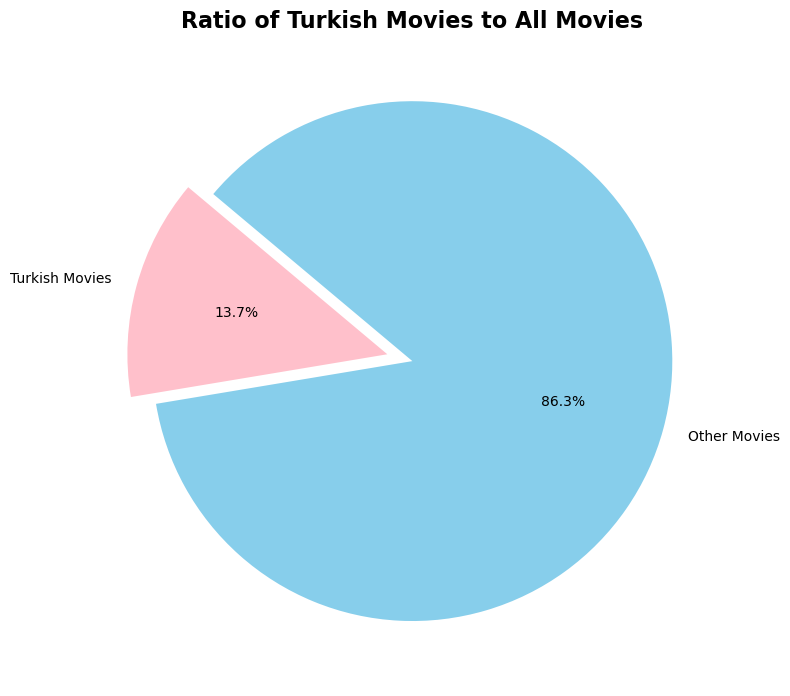

Total Movies: 524
Turkish Movies: 72
Ratio of Turkish Movies to All Movies: 13.74%


In [ ]:


file_path = "tmdb_movie_list_with_genres.csv" 
df = pd.read_csv(file_path)


if 'original_language' in df.columns:
    
    total_movies = len(df)

 
    turkish_movies = len(df[df['original_language'] == 'tr'])

   
    other_movies = total_movies - turkish_movies

   
    labels = ['Turkish Movies', 'Other Movies']
    sizes = [turkish_movies, other_movies]
    colors = ['pink', 'skyblue']
    explode = (0.1, 0)  

   
    plt.figure(figsize=(8, 8))
    plt.pie(
        sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, explode=explode
    )
    plt.title('Ratio of Turkish Movies to All Movies', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

   
    print(f"Total Movies: {total_movies}")
    print(f"Turkish Movies: {turkish_movies}")
    print(f"Ratio of Turkish Movies to All Movies: {turkish_movies / total_movies:.2%}")
else:
    print("The 'original_language' column is not present in the dataset.")



# Yearly Ratio of Turkish Movies Watched to Total Movies Watched

This code filters the Turkish movies from TMDB, matches them with the Netflix data, and groups the data by year. It then computes the ratio of Turkish movies watched each year compared to total movies watched. 

Yearly Ratios of Turkish Movies to Total Movies Watched:
Year
2017         NaN
2018    0.008130
2019    0.003984
2020    0.008065
2021    0.035294
2022    0.006944
2023    0.005464
2024    0.010909
dtype: float64


/var/folders/f1/02wxmwhx3zzfl_6bvqb3dsxm0000gn/T/ipykernel_94906/3712701284.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  netflix_data['Date'] = pd.to_datetime(netflix_data['Date'], errors='coerce')  # Ensure correct date format
/var/folders/f1/02wxmwhx3zzfl_6bvqb3dsxm0000gn/T/ipykernel_94906/3712701284.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  watched_turkish_movies['Year'] = watched_turkish_movies['Date'].dt.year


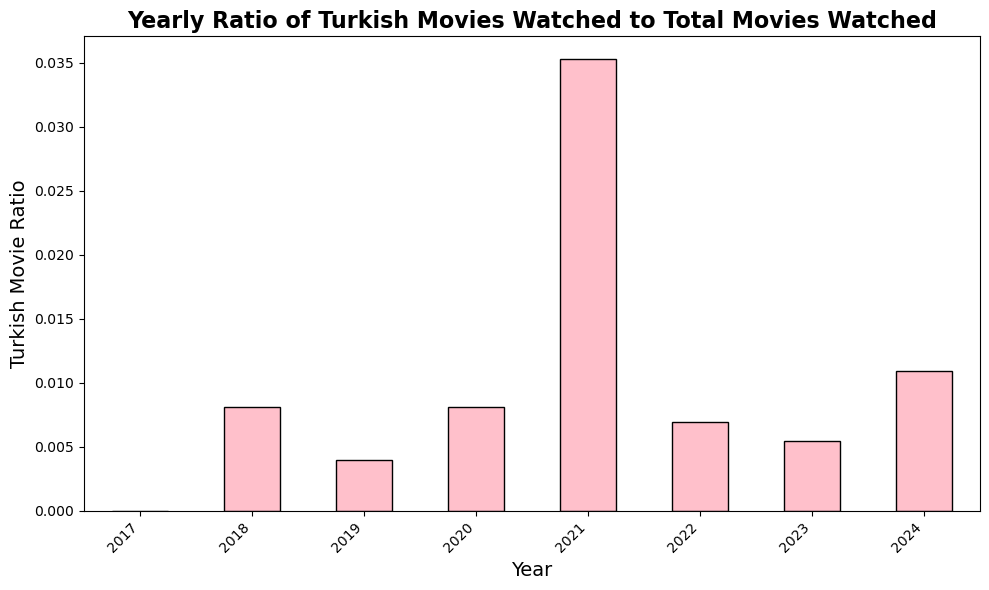

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


tmdb_file_path = "tmdb_movie_list_with_genres.csv"  
tmdb_data = pd.read_csv(tmdb_file_path)


netflix_file_path = "NetflixViewingHistory (1).csv"  
netflix_data = pd.read_csv(netflix_file_path)


turkish_movies_tmdb = tmdb_data[tmdb_data['original_language'] == 'tr']


netflix_data['Date'] = pd.to_datetime(netflix_data['Date'], errors='coerce')  
netflix_data = netflix_data.dropna(subset=['Date']) 


watched_turkish_movies = netflix_data[netflix_data['Title'].isin(turkish_movies_tmdb['title'])]


netflix_data['Year'] = netflix_data['Date'].dt.year
total_movies_per_year = netflix_data.groupby('Year').size()


watched_turkish_movies['Year'] = watched_turkish_movies['Date'].dt.year
watched_turkish_per_year = watched_turkish_movies.groupby('Year').size()


yearly_ratios = watched_turkish_per_year / total_movies_per_year


print("Yearly Ratios of Turkish Movies to Total Movies Watched:")
print(yearly_ratios)


plt.figure(figsize=(10, 6))
yearly_ratios.plot(kind='bar', color='pink', edgecolor='black')
plt.title('Yearly Ratio of Turkish Movies Watched to Total Movies Watched', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Turkish Movie Ratio', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


This code loads and combines Spotify JSON data, extracts artist names and listening years, filters the data for 2019-2024, and saves the cleaned dataset to a CSV file for future analysis.

In [ ]:
import pandas as pd
import os
import json

directory_path = './'  


all_data = []


for filename in os.listdir(directory_path):
    if filename.endswith('.json'):
        file_path = os.path.join(directory_path, filename)
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)
            all_data.extend(data)  


df = pd.DataFrame(all_data)

df['ts'] = pd.to_datetime(df['ts'], errors='coerce')


df['Year'] = df['ts'].dt.year


df_filtered = df[df['Year'].between(2019, 2024)]


df_filtered = df_filtered[['master_metadata_album_artist_name', 'Year']].dropna()


print("Displaying the first few rows of the dataset:")
print(df_filtered.head())

df_filtered.to_csv('spotify_artist_year_data.csv', index=False)

pd.set_option('display.max_columns', None)
print(df_filtered.head())

print("Data for artists and year extracted and saved as 'spotify_artist_year_data.csv'.")


Displaying the first few rows of the dataset:
   master_metadata_album_artist_name  Year
17                            Reckol  2023
18                       The Beatles  2023
19                          Coldplay  2023
20                             Metic  2024
21                        Tuğba Yurt  2024
   master_metadata_album_artist_name  Year
17                            Reckol  2023
18                       The Beatles  2023
19                          Coldplay  2023
20                             Metic  2024
21                        Tuğba Yurt  2024
Data for artists and year extracted and saved as 'spotify_artist_year_data.csv'.


This code reads the spotify_artist_year_data.csv file, renames the column master_metadata_album_artist_name to artist_name, and then saves the updated DataFrame to a new CSV file called spotify_artist_year_data_updated.csv. 

In [ ]:
import pandas as pd


spotify_data = pd.read_csv("spotify_artist_year_data.csv") 

spotify_data.rename(columns={'master_metadata_album_artist_name': 'artist_name'}, inplace=True)

spotify_data.to_csv("spotify_artist_year_data_updated.csv", index=False)

print(spotify_data.head())


   artist_name  Year
0       Reckol  2023
1  The Beatles  2023
2     Coldplay  2023
3        Metic  2024
4   Tuğba Yurt  2024


This code merges Spotify artist-year data with genre and track count information. It processes the genres, identifies Turkish music, and calculates the ratio of Turkish music tracks to total tracks for each year. The final result shows the yearly ratio of Turkish music to all music tracks.

In [ ]:
import pandas as pd

artist_data = pd.read_csv("Artist_Data_with_Genres.csv")  
spotify_data = pd.read_csv("spotify_artist_year_data_updated.csv")  


merged_data = pd.merge(spotify_data, artist_data[['artist_name', 'genres', 'track_count']], 
                       on='artist_name', how='left')


merged_data['genres'] = merged_data['genres'].fillna('Unknown')
merged_data['track_count'] = merged_data['track_count'].fillna(0) 


merged_data['genres'] = merged_data['genres'].str.split(', ')


merged_data_exploded = merged_data.explode('genres')


merged_data_exploded = merged_data_exploded[merged_data_exploded['genres'] != 'Unknown']


merged_data_exploded['is_turkish'] = merged_data_exploded['genres'].apply(lambda x: 'turkish' in x.lower())


yearly_data_total = merged_data_exploded.groupby('Year').agg(
    total_tracks=('track_count', 'sum')
).reset_index()


yearly_data_turkish = merged_data_exploded[merged_data_exploded['is_turkish']].groupby('Year').agg(
    turkish_tracks=('track_count', 'sum')
).reset_index()


yearly_data = pd.merge(yearly_data_total, yearly_data_turkish, on='Year', how='left')


yearly_data['turkish_tracks'] = yearly_data['turkish_tracks'].fillna(0)


yearly_data['turkish_music_ratio'] = yearly_data['turkish_tracks'] / yearly_data['total_tracks']


print(yearly_data[['Year', 'turkish_music_ratio']])


   Year  turkish_music_ratio
0  2019             0.240432
1  2020             0.155224
2  2021             0.290633
3  2022             0.205128
4  2023             0.275152
5  2024             0.529906


# Correlation Between Listening Turkish Music and Watching Turkish Movies(2019-2024)


This heatmap shows the correlation between listening to Turkish music and watching Turkish movies from 2019 to 2024. The correlation of 0.16 indicates a weak positive relationship, meaning that people who listen to Turkish music tend to watch Turkish movies, but the correlation is not very strong. The color scale reflects this weak relationship, with blue representing a low correlation and red representing a high one

                     turkish_movie_ratio  turkish_music_ratio
turkish_movie_ratio             1.000000             0.155884
turkish_music_ratio             0.155884             1.000000


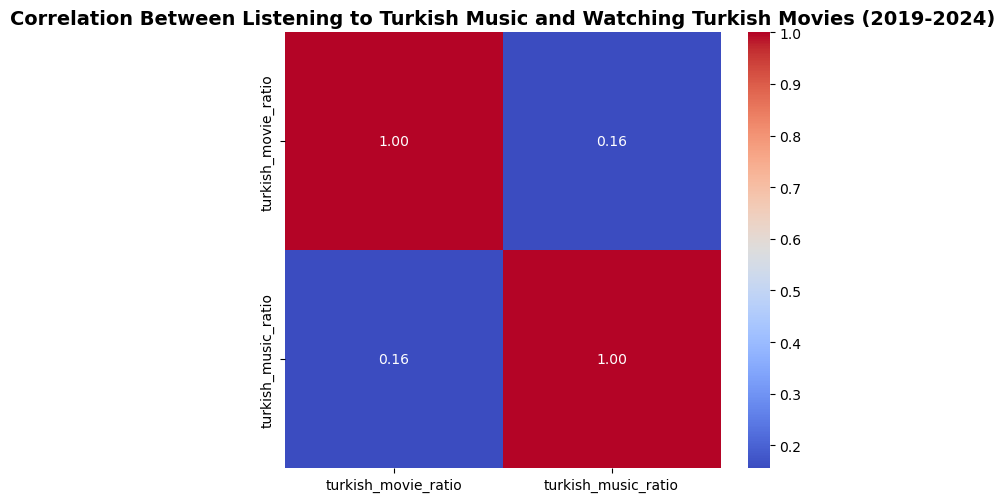

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


movie_data = {
    'Year': [2019, 2020, 2021, 2022, 2023, 2024],  
    'turkish_movie_ratio': [0.003984, 0.008065, 0.035294, 0.006944, 0.005464, 0.010909] 
}


music_data = {
    'Year': [2019, 2020, 2021, 2022, 2023, 2024],
    'turkish_music_ratio': [0.240432, 0.155224, 0.290633, 0.205128, 0.275152, 0.529906]
}


movie_df = pd.DataFrame(movie_data)
music_df = pd.DataFrame(music_data)


merged_data = pd.merge(movie_df, music_df, on='Year', how='inner')


correlation_matrix = merged_data[['turkish_movie_ratio', 'turkish_music_ratio']].corr()


print(correlation_matrix)


plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, square=True)
plt.title('Correlation Between Listening to Turkish Music and Watching Turkish Movies (2019-2024)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


# Song Genres vs. Movie Genres

This code compares the relationship between the most listened to song genres and the most watched movie genres based on selected categories. The top 5 song genres (e.g., 'turkish rock', 'turkish pop', 'rock', 'turkish alt pop', 'dinner jazz') and the top 5 movie genres (e.g., 'Drama', 'Comedy', 'Crime', 'Romance', 'Action') are used for analysis. Each genre is associated with a descriptive category (such as 'Dramatic', 'Vibrant', etc.), and the listening time and movie watch count are normalized. The code then merges the song and movie data based on their genre descriptions and calculates the correlation between the normalized listening time and movie watch count. 

This scatter plot with a regression line shows the correlation between normalized listening time to song genres and normalized movie watch count by movie genres. The correlation value of 0.75 indicates a strong positive relationship. This suggests that the type of music listened to and the type of movies watched have a strong correlation. This means we can make recommendations based on the most liked and most listened-to music genres, as well as the most watched movie genres.

Correlation between listening to song genres and watching movie genres: 0.75


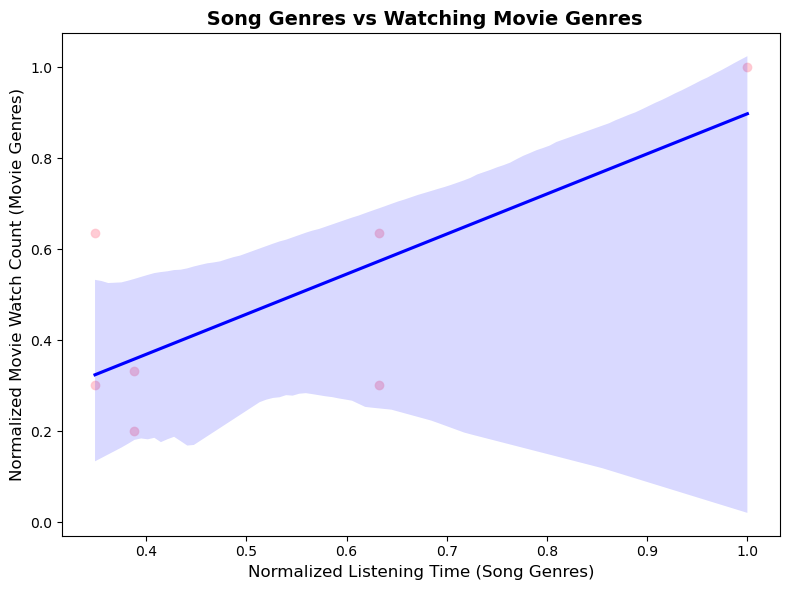

In [89]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


genre_to_description = {
    'turkish rock': 'Dramatic',
    'turkish pop': 'Vibrant',
    'rock': 'Energetic',
    'turkish alt pop': 'Vibrant',
    'dinner jazz': 'Relaxing',
    'background music': 'Relaxing',
    'turkish alternative rock': 'Dramatic',
    'pop': 'Vibrant',
    'modern rock': 'Energetic',
    'rap': 'Energetic'
}


song_genres = {
    'turkish rock': 52518.21,
    'turkish pop': 33200.07,
    'rock': 20377.93,
    'turkish alt pop': 18323.86,
    'dinner jazz': 17862.40
}


movie_genres = {
    'Drama': 288,
    'Comedy': 183,
    'Crime': 96,
    'Romance': 87,
    'Action': 58
}


song_df = pd.DataFrame(list(song_genres.items()), columns=['genre', 'listened_minutes'])
movie_df = pd.DataFrame(list(movie_genres.items()), columns=['genre', 'watched_count'])


song_df['normalized_listened_minutes'] = song_df['listened_minutes'] / song_df['listened_minutes'].max()
movie_df['normalized_watched_count'] = movie_df['watched_count'] / movie_df['watched_count'].max()


song_df['genre'] = song_df['genre'].str.lower().str.strip()
movie_df['genre'] = movie_df['genre'].str.lower().str.strip()


song_df['description'] = song_df['genre'].map(genre_to_description)
movie_df['description'] = movie_df['genre'].map({
    'drama': 'Dramatic', 'comedy': 'Vibrant', 'crime': 'Energetic', 'romance': 'Vibrant', 'action': 'Energetic'
})


merged_df = pd.merge(song_df, movie_df, on='description', how='inner')


correlation = merged_df[['normalized_listened_minutes', 'normalized_watched_count']].corr().iloc[0, 1]


print(f"Correlation between listening to song genres and watching movie genres: {correlation:.2f}")


plt.figure(figsize=(8, 6))
sns.regplot(x='normalized_listened_minutes', y='normalized_watched_count', data=merged_df, scatter_kws={'color': 'pink'}, line_kws={'color': 'blue'})
plt.title(' Song Genres vs Watching Movie Genres', fontsize=14, fontweight='bold')
plt.xlabel('Normalized Listening Time (Song Genres)', fontsize=12)
plt.ylabel('Normalized Movie Watch Count (Movie Genres)', fontsize=12)
plt.tight_layout()
plt.show()
